In [130]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import levy_stable, norm
from typing import Union
from finmath1 import BlackScholes

In [131]:
def simulate_brownian(S0, mu, sigma, T, n_steps):
    """
    Геометрическое броуновское движение:
    S[i+1] = S[i] * exp((mu - 0.5 * sigma ** 2) * dt + sigma * sqrt(dt) * Z[i])
    Z ~ N(0,1)
    """

    dt = T / n_steps
    times = np.linspace(0.0, T, n_steps + 1)
    S = np.empty(n_steps + 1, dtype=float)
    S[0] = S0

    Z = norm.rvs(size=n_steps)

    for i in range(n_steps):
        S[i + 1] = S[i] * np.exp((mu - 0.5 * sigma ** 2) * dt + sigma * np.sqrt(dt) * Z[i])

    return times, S

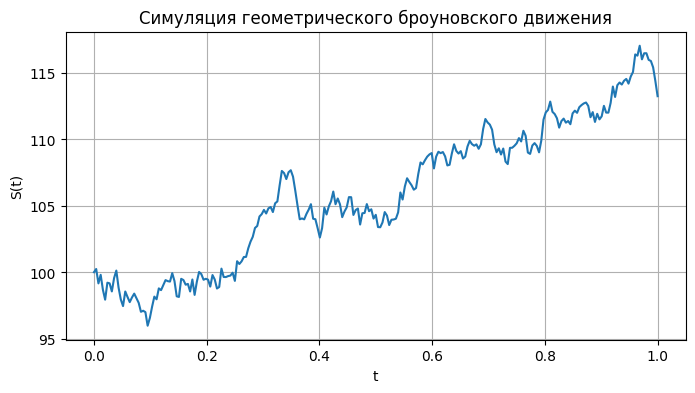

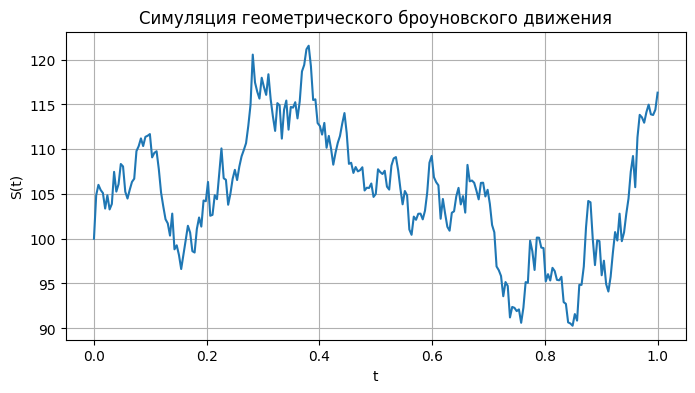

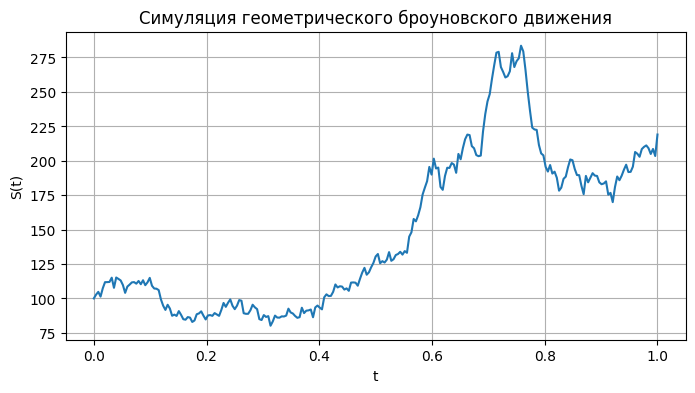

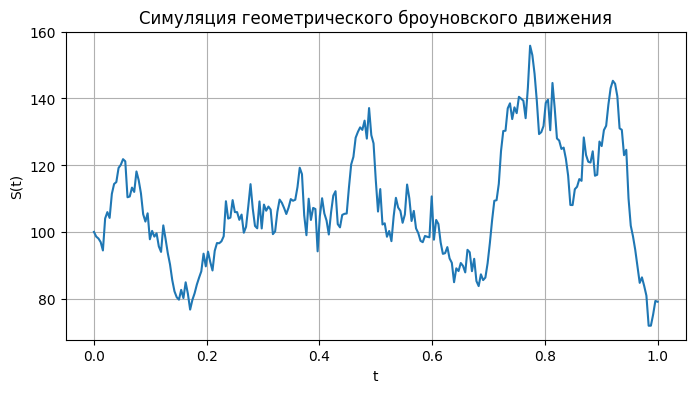

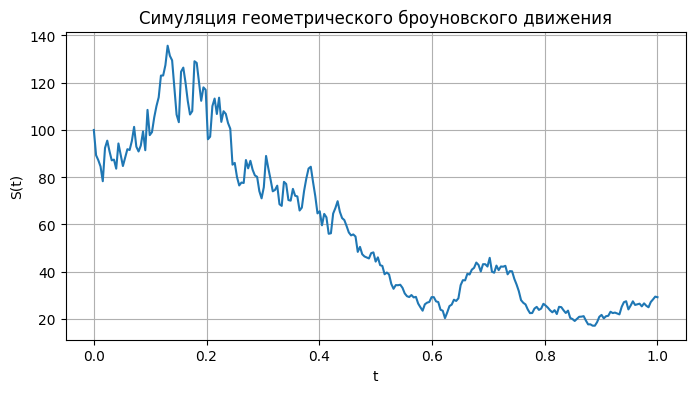

In [132]:
X0 = 100.0
mu = 0.1
T = 1.0
n_steps = 252

for sigma in np.linspace(0.1, 1.0, 5):
    times, S = simulate_brownian(X0, mu, sigma, T, n_steps)

    plt.figure(figsize=(8, 4))
    plt.plot(times, S)
    plt.xlabel("t")
    plt.ylabel("S(t)")
    plt.title("Cимуляция геометрического броуновского движения")
    plt.grid(True)
    plt.show()

In [133]:
import numpy as np


def sample_s_distr(alpha: float = 0.5, gamma: float = 1, num_generations: int = 1):
    pi = np.pi
    U = np.random.uniform(-pi / 2, pi / 2, size=num_generations)
    W = np.random.exponential(1, size=num_generations)

    U_0 = -1 / 2 * pi * (1 - abs(1 - alpha)) / alpha
    term1 = np.sin(alpha * (U - U_0)) / np.power(np.cos(U), 1 / alpha)
    term2 = np.power(np.cos(U - alpha * (U - U_0)) / W, (1 - alpha) / alpha)

    values = term1 * term2 * gamma

    return values


def sample_tau(alpha: float, T: float, t: float, n_paths: int = 1):
    # gamma = np.power(1 / 252, 1 / alpha)
    # stable_S = sample_s_distr(alpha, gamma=gamma, num_generations=n_paths) + t
    # tau = (T ** alpha) / (stable_S ** alpha)
    # return tau * gamma
    
    scale = (T**alpha - t**alpha) ** (1 / alpha)
    S = sample_s_distr(alpha, gamma=1.0, num_generations=n_paths)
    tau = scale / (S ** (1 / alpha))
    return tau


def monte_carlo_vanilla(alpha: float,
                        T: float,
                        t: float,
                        S0: float,
                        K: float,
                        mu: float,
                        sigma: float,
                        r: float,
                        payoff: str = 'call',
                        n_paths: int = 1
                        ):
    
    tau = sample_tau(alpha, T, t, n_paths)
    Z = np.random.randn(n_paths)
    S_tau = S0 * np.exp((mu - 0.5 * sigma ** 2) * tau + sigma * np.sqrt(tau) * Z)
    
    if payoff == "call":
        payoff_vec = np.maximum(S_tau - K, 0.0) * np.exp(-r * (T - t))
    elif payoff == "put":
        payoff_vec = np.maximum(K - S_tau, 0.0) * np.exp(-r * (T - t))
    else:
        raise ValueError("payoff must be 'call' or 'put'")
        
    return payoff_vec.mean()

In [134]:
alpha = 1.0
T = 1
S0 = 100.0
K = 102.0
sigma = 0.2
r = 0.1
mu = r
n_paths = 500_000
t = 0.0
    
# print(sample_tau(alpha=1, T=1.0, t=0.5, n_paths=100).mean())
print('Monte Carlo Vanilla (alpha = 1): CALL')
print(monte_carlo_vanilla(alpha=alpha, T=T, t=t, S0=S0, K=K, sigma=sigma, mu=mu, r=r, payoff='call', n_paths=n_paths))
print('Monte Carlo Vanilla (alpha = 1): PUT')
print(monte_carlo_vanilla(alpha=alpha, T=T, t=t, S0=S0, K=K, sigma=sigma, mu=mu, r=r, payoff='put', n_paths=n_paths))
print()
    
model = BlackScholes(sigma=sigma, r=r)
print('Black Scholes: CALL')
print(model.call_price(S0, T - t, K))
print('Black Scholes: PUT')
print(model.put_price(S0, T - t, K))

Monte Carlo Vanilla (alpha = 1): CALL
12.097768452469035
Monte Carlo Vanilla (alpha = 1): PUT
4.395392007288156

Black Scholes: CALL
12.117093220879717
Black Scholes: PUT
4.410509860547581
